# **Download**

In [1]:
!gdown 1oASNDwimfBI1a0PfKb2CwBd4ajLlM15J
!gdown 1Zfb0UFlqX1XyTXA8eQmNGNjxChL2jeT3
!gdown 195P4Hb5H_JZkVADsz3mj4MJZ18NMHeMX
!gdown 1Srx0e8Nr08rJTgXRgkWlz_jEqiF8qry6
!gdown 1XhJCD8MXNF8QPyn9k5nX7LL2maJrJoax
!gdown 1L4NdvtvnOGEsHQW8Hh2tV_3-Awhu_rod

Downloading...
From: https://drive.google.com/uc?id=1oASNDwimfBI1a0PfKb2CwBd4ajLlM15J
To: /content/dataloader_demo.ipynb
100% 5.79k/5.79k [00:00<00:00, 17.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Zfb0UFlqX1XyTXA8eQmNGNjxChL2jeT3
To: /content/exploring_data.py
100% 3.27k/3.27k [00:00<00:00, 15.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=195P4Hb5H_JZkVADsz3mj4MJZ18NMHeMX
To: /content/triplet_loss.py
100% 2.88k/2.88k [00:00<00:00, 15.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Srx0e8Nr08rJTgXRgkWlz_jEqiF8qry6
To: /content/utils.py
100% 5.76k/5.76k [00:00<00:00, 20.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XhJCD8MXNF8QPyn9k5nX7LL2maJrJoax
To: /content/12000_test_mnistmnistmsvhnsynusps.npz
100% 70.6M/70.6M [00:00<00:00, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1L4NdvtvnOGEsHQW8Hh2tV_3-Awhu_rod
To: /content/12000_train_mnistmnistmsvhnsynusps.npz
100% 197M/197M [00:01<00:00, 111MB/s] 


# **Import**

In [ ]:
from utils import get_data_loaders
from triplet_loss import triplet_loss
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# **Loading Method**

In [ ]:
def loaders_demo():
    full_dataloaders, _ = get_data_loaders(
        filenames={
            'train': '12000_train_mnistmnistmsvhnsynusps.npz',
            'test': '12000_test_mnistmnistmsvhnsynusps.npz',
        },
        batch_size= 64
    )
    print(full_dataloaders.keys())

    for phase in ['train', 'test', 'test_missing']:
        print(f'{phase} data size: ', full_dataloaders[f'{phase}_size'])
        for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(full_dataloaders[phase]):
            print(f'{batch_indx}-th batch')
            print('images shape: ', images.shape)
            print('features shape: ', features.shape)
            if phase == 'test_missing':
                print('in test-missing dataloaders, since the features are not available, features are filled with zeros', torch.sum(features))
            print('domain labels freq: ', torch.unique(domain_labels, return_counts=True))
            print('digit labels freq: ', torch.unique(digit_labels, return_counts=True))
            print()
            break
loaders_demo()

datafiles to read:  {'train': '12000_train_mnistmnistmsvhnsynusps.npz', 'test': '12000_test_mnistmnistmsvhnsynusps.npz'}
reading 12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading 12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading 12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
dict_keys(['train', 'test', 'test_missing', 'train_size', 'test_size', 'test_missing_size'])
train data size:  60000
0-th batch
images shape:  torch.Size([64, 3, 32, 32])
features shape:  torch.Size([64, 256])
domain labels freq:  (tensor([0, 1, 2, 3, 4]), tensor([10, 13, 11, 18, 12]))
digit labels freq:  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 6,  5,  8,  5,  6,  9, 10,  7,  5,  3]))

test data size:  21600
0-th batch
images shape:  torch.Size([64, 3, 32, 32])
features shape:  torch.Size([64, 256])
domain labels freq:  (tensor([0, 1, 2, 3, 4]), tensor([ 9,  9, 17, 15, 14]))
digit labels freq:  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 

# **Data Loading**

In [ ]:
full_dataloaders, _ = get_data_loaders(
        filenames={
            'train': '12000_train_mnistmnistmsvhnsynusps.npz',
            'test': '12000_test_mnistmnistmsvhnsynusps.npz',
        },
        batch_size= 64
    )
train = full_dataloaders['train']
test = full_dataloaders['test']
missing = full_dataloaders['test_missing']
# for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(train):
#             print(images.shape)
#             break

datafiles to read:  {'train': '12000_train_mnistmnistmsvhnsynusps.npz', 'test': '12000_test_mnistmnistmsvhnsynusps.npz'}
reading 12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading 12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading 12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


# **Model (First Try)**

In [ ]:
class CombinedModel2(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU()
        )
        self.fc_img = nn.Linear(32 * 32 * 32, 256)
        self.fc_combined = nn.Linear(512, 256)# Concatenated feature and image size
        self.fc_combined2 = nn.Linear(256, 10)

    def forward(self, x_img, x_features):
        x_img = self.conv1(x_img)
        x_img = self.conv2(x_img)
        x_img = x_img.view(x_img.size(0), -1)  # Flatten the image
        x_img = self.fc_img(x_img)

        # Concatenate features and image representations
        x_combined = torch.cat((x_img, x_features), dim=1)

        # Fully connected layers for prediction
        x_combined = self.fc_combined(x_combined)
        x_combined2 = self.fc_combined2(x_combined)
        return x_combined2

In [ ]:
# margin: 0.005 and lambda: 0
a = 0
model = CombinedModel2()
crossLoss = nn.CrossEntropyLoss()
triplet = triplet_loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 10
for epoch in range(epochs):
  model.train()
  running_corrects = 0
  running_loss = 0.0
  num_samples = len(train.dataset)
  num_batches = len(train)
  for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(train):
    outs = model(images, features)
    loss1 = crossLoss(outs, digit_labels)

    # this loss is for domain labels (update later...)
    # loss2 = triplet(outs, digit_labels)

    # total_loss = loss1 + a * loss2

    loss1.backward()
    optimizer.step()
    optimizer.zero_grad()
    _, preds = torch.max(outs, dim=1) # Explain, [N]
    running_corrects += torch.sum(preds == digit_labels)
    running_loss += loss1.item()


  epoch_acc = (running_corrects / num_samples) * 100
  epoch_loss = (running_loss / num_batches)
  print(epoch_acc)
  print(epoch_loss)


  num_samples_test = len(test.dataset)
  num_batches_test = len(test)
  running_corrects_test = 0
  running_loss_test = 0.0


  model.eval() # you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.
  with torch.no_grad(): # explain
      # more on torch.no_grad(): https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#disabling-gradient-tracking

      for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(test): # Get a batch of Data

          outputs = model(images, features) # Forward Pass
          loss = crossLoss(outputs, digit_labels) # Compute Loss

          # loss.backward() # Compute Gradients
          # optim.step() # Update parameters
          # optim.zero_grad() # zero the parameter's gradients

          _, preds = torch.max(outputs, 1) #
          running_corrects_test += torch.sum(preds == digit_labels)
          running_loss_test += loss.item()

  test_acc = (running_corrects_test / num_samples_test) * 100
  test_loss = (running_loss_test / num_batches_test)
  print(test_acc)
  print(test_loss)

tensor(47.2983)
1.7020510615570459
tensor(51.3565)
1.5375995064628194
tensor(59.5717)
1.2787628383524636
tensor(69.1898)
0.9718344797044111
tensor(76.1600)
0.7707249532693993
tensor(80.0463)
0.658575889362386
tensor(81.9283)
0.5900874832577543
tensor(83.2870)
0.5708600082076513
tensor(84.4167)
0.5187758084839341
tensor(83.4259)
0.5617636193978716
tensor(85.4400)
0.48417612149326533
tensor(84.0787)
0.5432060827341305
tensor(86.2383)
0.4578201708985544
tensor(84.2685)
0.5401536630543732
tensor(86.9200)
0.43417919178538994
tensor(84.6991)
0.5265429215671042
tensor(87.4550)
0.4175378336453997
tensor(84.8380)
0.5301689260016532
tensor(88.0433)
0.39747335602130207
tensor(85.7269)
0.5028339879664444


In [ ]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_img = nn.Linear(32 * 8 * 8, 256)
        self.fc_combined = nn.Linear(512, 256)# Concatenated feature and image size
        self.fc_combined2 = nn.Linear(256, 10)

    def forward(self, x_img, x_features):
        x_img = self.conv1(x_img)
        x_img = self.conv2(x_img)
        x_img = x_img.view(x_img.size(0), -1)  # Flatten the image
        x_img = self.fc_img(x_img)

        # Concatenate features and image representations
        x_combined = torch.cat((x_img, x_features), dim=1)

        # Fully connected layers for prediction
        x_combined = self.fc_combined(x_combined)
        x_combined2 = self.fc_combined2(x_combined)
        return x_combined2, x_combined

In [ ]:
# margin: 0.005 and lambda: 0.2
a = 0.2
model = CombinedModel()
crossLoss = nn.CrossEntropyLoss()
triplet = triplet_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
  print('epoch: ' + str(epoch))
  model.train()
  running_corrects = 0
  running_loss = 0.0
  num_samples = len(train.dataset)
  num_batches = len(train)
  for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(train):

    outs2, outs = model(images, features)

    loss1 = crossLoss(outs2, digit_labels)
    loss2 = triplet(outs, domain_labels)
    total_loss = loss1 + a * loss2

    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    _, preds = torch.max(outs2, dim=1) # Explain, [N]
    running_corrects += torch.sum(preds == digit_labels)
    running_loss += total_loss.item()

  epoch_acc = (running_corrects / num_samples) * 100
  epoch_loss = (running_loss / num_batches)
  print(epoch_acc)
  print(epoch_loss)


  num_samples_test = len(test.dataset)
  num_batches_test = len(test)
  running_corrects_test = 0
  running_loss_test = 0.0


  model.eval() # you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.
  with torch.no_grad(): # explain
      # more on torch.no_grad(): https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#disabling-gradient-tracking

      for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(test): # Get a batch of Data

          outputs2, outputs = model(images, features) # Forward Pass
          loss = crossLoss(outputs2, digit_labels) # Compute Loss
          loss2 = triplet(outputs, domain_labels)
          total_loss = loss + a * loss2

          _, preds = torch.max(outputs2, 1) #
          running_corrects_test += torch.sum(preds == digit_labels)
          running_loss_test += total_loss.item()

  test_acc = (running_corrects_test / num_samples_test) * 100
  test_loss = (running_loss_test / num_batches_test)
  print(test_acc)
  print(test_loss)
  print()

epoch: 0
tensor(78.1767)
1.0990127398451763
tensor(84.3657)
1.1633740772862406

epoch: 1
tensor(87.2500)
0.6564978392266515
tensor(87.0787)
1.4364582007453286

epoch: 2
tensor(89.0567)
0.5723801645071014
tensor(87.2963)
1.3237379376704876

epoch: 3
tensor(90.0050)
0.5190424712767987
tensor(88.1713)
1.1418375200068458

epoch: 4
tensor(90.7500)
0.4819496440321906
tensor(88.2083)
1.248982205898804

epoch: 5
tensor(91.1933)
0.4553994424879424
tensor(88.6111)
1.1107811735579247

epoch: 6
tensor(91.9600)
0.4255849871633531
tensor(88.9352)
1.0354671809800278

epoch: 7
tensor(92.2033)
0.4134324026514472
tensor(88.6713)
1.1672119134981958

epoch: 8
tensor(92.4467)
0.3974411038161595
tensor(87.9537)
1.158520528197994

epoch: 9
tensor(92.8867)
0.3789314676258864
tensor(89.3241)
1.2218802289144528



In [ ]:
# margin: 0.05 and lambda: 0.15
a = 0.15
model = CombinedModel()
crossLoss = nn.CrossEntropyLoss()
triplet = triplet_loss(margin=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
  print('epoch: ' + str(epoch))
  model.train()
  running_corrects = 0
  running_loss = 0.0
  num_samples = len(train.dataset)
  num_batches = len(train)
  for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(train):

    outs2, outs = model(images, features)

    loss1 = crossLoss(outs2, digit_labels)
    loss2 = triplet(outs, domain_labels)
    total_loss = loss1 + a * loss2

    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    _, preds = torch.max(outs2, dim=1) # Explain, [N]
    running_corrects += torch.sum(preds == digit_labels)
    running_loss += total_loss.item()

  epoch_acc = (running_corrects / num_samples) * 100
  epoch_loss = (running_loss / num_batches)
  print(epoch_acc)
  print(epoch_loss)


  num_samples_test = len(test.dataset)
  num_batches_test = len(test)
  running_corrects_test = 0
  running_loss_test = 0.0


  model.eval() # you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.
  with torch.no_grad(): # explain
      # more on torch.no_grad(): https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#disabling-gradient-tracking

      for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(test): # Get a batch of Data

          outputs2, outputs = model(images, features) # Forward Pass
          loss = crossLoss(outputs2, digit_labels) # Compute Loss
          loss2 = triplet(outputs, domain_labels)
          total_loss = loss + a * loss2

          _, preds = torch.max(outputs2, 1) #
          running_corrects_test += torch.sum(preds == digit_labels)
          running_loss_test += total_loss.item()

  test_acc = (running_corrects_test / num_samples_test) * 100
  test_loss = (running_loss_test / num_batches_test)
  print(test_acc)
  print(test_loss)
  print()

epoch: 0
tensor(76.5350)
1.0565632909282183
tensor(84.5648)
0.7265627738639447

epoch: 1
tensor(86.3867)
0.5956343043206344
tensor(86.4074)
0.6579723594456734

epoch: 2
tensor(87.9933)
0.5027762494965403
tensor(85.6620)
0.7908591673924372

epoch: 3
tensor(89.2117)
0.45318882272981886
tensor(86.9769)
0.6175758858933251

epoch: 4
tensor(90.1533)
0.41575332109862045
tensor(87.1481)
0.605746651013222

epoch: 5
tensor(90.4733)
0.39169425989137785
tensor(88.2685)
0.5877323985628827

epoch: 6
tensor(91.2217)
0.3679653053312922
tensor(87.7870)
0.607917448869471

epoch: 7
tensor(91.6717)
0.3472968633574591
tensor(87.8333)
0.6373053320501683

epoch: 8
tensor(91.9767)
0.33660663800167123
tensor(88.3704)
0.5811972328897058

epoch: 9
tensor(92.3667)
0.31619173244658566
tensor(87.4630)
0.6191634790608164



# **Fit Function**

In [ ]:
def fit(margin, lambd):
  model = CombinedModel()
  crossLoss = nn.CrossEntropyLoss()
  triplet = triplet_loss(margin=margin)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  epochs = 10
  for epoch in range(epochs):
    print('epoch: ' + str(epoch))
    model.train()
    running_corrects = 0
    running_loss = 0.0
    triplet_total = 0.0
    entropy_total = 0.0

    num_samples = len(train.dataset)
    num_batches = len(train)
    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(train):

      outs2, outs = model(images, features)

      loss1 = crossLoss(outs2, digit_labels)
      loss2 = triplet(outs, domain_labels)
      total_loss = loss1 + lambd * loss2

      total_loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      _, preds = torch.max(outs2, dim=1) # Explain, [N]
      running_corrects += torch.sum(preds == digit_labels)
      running_loss += total_loss.item()
      triplet_total += loss2.item()
      entropy_total += loss1.item()

    epoch_acc = (running_corrects / num_samples) * 100
    epoch_loss = (running_loss / num_batches)
    triplet_total  = (triplet_total / num_batches)
    entropy_total = (entropy_total / num_batches)
    print('train')
    print('accuaray: ' + str(epoch_acc))
    print('total loss: ' + str(epoch_loss))
    print('triplet loss: ' + str(loss2))
    print('cross entropy loss: ' + str(loss1))
    print('---------------')


    num_samples_test = len(test.dataset)
    num_batches_test = len(test)
    running_corrects_test = 0
    running_loss_test = 0.0
    triplet_total = 0.0
    entropy_total = 0.0


    model.eval() # you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.
    with torch.no_grad(): # explain
        # more on torch.no_grad(): https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#disabling-gradient-tracking

        for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(test): # Get a batch of Data

            outputs2, outputs = model(images, features) # Forward Pass
            loss = crossLoss(outputs2, digit_labels) # Compute Loss
            loss2 = triplet(outputs, domain_labels)
            total_loss = loss + lambd * loss2

            _, preds = torch.max(outputs2, 1) #
            running_corrects_test += torch.sum(preds == digit_labels)
            running_loss_test += total_loss.item()
            triplet_total += loss2.item()
            entropy_total += loss.item()

    test_acc = (running_corrects_test / num_samples_test) * 100
    test_loss = (running_loss_test / num_batches_test)
    triplet_total = (triplet_total / num_batches_test)
    entropy_total = (entropy_total / num_batches_test)
    print('test')
    print('accuray: ' + str(test_acc))
    print('total loss: ' + str(test_loss))
    print('triplet loss: ' + str(triplet_total))
    print('cross entropy loss: ' + str(entropy_total))

In [ ]:
for m in [0.001, 0.005, 0.025]:
  for l in [0.1, 0.2, 0.3]:
    print('margin: ' + str(m) + ' lambda: ' + str(l))
    fit(margin=m, lambd=l)

margin: 0.001 lambda: 0.1
epoch: 0
train
accuaray: tensor(77.3883)
total loss: 0.9857330186280615
triplet loss: tensor(2.2516, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.8198, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(85.2500)
total loss: 0.6607284118261563
triplet loss: 1.7836046001967594
cross entropy loss: 0.48236794990195325
epoch: 1
train
accuaray: tensor(86.6767)
total loss: 0.5646098479628563
triplet loss: tensor(0.8967, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.3350, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(86.7870)
total loss: 0.6138867261494405
triplet loss: 1.8040978975549957
cross entropy loss: 0.43347693195004433
epoch: 2
train
accuaray: tensor(88.4467)
total loss: 0.47446373734932973
triplet loss: tensor(0.9114, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.2998, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(87.0463)
total loss: 0.5737707739221979
triplet loss: 1.4922960557308

# **Without Triplet Loss**

In [ ]:
fit(0, 0)

epoch: 0
train
accuaray: tensor(79.7267)
total loss: 0.6454061842454013
triplet loss: tensor(25.0355, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.5330, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(87.6898)
total loss: 0.42346566681854825
triplet loss: 28.07178208954941
cross entropy loss: 0.42346566681854825
epoch: 1
train
accuaray: tensor(88.5000)
total loss: 0.37234022509632336
triplet loss: tensor(24.1905, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.3695, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(88.3472)
total loss: 0.38653587315165433
triplet loss: 34.493383514810596
cross entropy loss: 0.38653587315165433
epoch: 2
train
accuaray: tensor(90.5083)
total loss: 0.31015816150999653
triplet loss: tensor(34.6670, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.3504, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(89.)
total loss: 0.38369097181502176
triplet loss: 38.49339676467625
cross entropy loss: 0

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_img = nn.Linear(32 * 8 * 8, 256)
        self.fc_combined = nn.Linear(512, 256)# Concatenated feature and image size
        self.fc_domain = nn.Linear(256, 5)
        self.fc_combined2 = nn.Linear(256, 10)

    def forward(self, x_img, x_features):
        x_img = self.conv1(x_img)
        x_img = self.conv2(x_img)
        x_img = x_img.view(x_img.size(0), -1)  # Flatten the image
        x_img = F.relu(self.fc_img(x_img))

        # Concatenate features and image representations
        x_combined = torch.cat((x_img, x_features), dim=1)

        # Fully connected layers for prediction
        x_combined = F.relu(self.fc_combined(x_combined))
        x_combined2 = F.softmax(self.fc_combined2(x_combined))
        x_combined = F.softmax(self.fc_domain(x_combined))
        return x_combined2, x_combined

def fit(margin, lambd):
  model = CombinedModel()
  crossLoss = nn.CrossEntropyLoss()
  triplet = triplet_loss(margin=margin)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  epochs = 10
  for epoch in range(epochs):
    print('epoch: ' + str(epoch))
    model.train()
    running_corrects = 0
    running_loss = 0.0
    triplet_total = 0.0
    entropy_total = 0.0

    num_samples = len(train.dataset)
    num_batches = len(train)
    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(train):

      outs2, outs = model(images, features)

      loss1 = crossLoss(outs2, digit_labels)
      loss2 = triplet(outs, domain_labels)
      total_loss = loss1 + lambd * loss2

      total_loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      _, preds = torch.max(outs2, dim=1) # Explain, [N]
      running_corrects += torch.sum(preds == digit_labels)
      running_loss += total_loss.item()
      triplet_total += loss2.item()
      entropy_total += loss1.item()

    epoch_acc = (running_corrects / num_samples) * 100
    epoch_loss = (running_loss / num_batches)
    triplet_total  = (triplet_total / num_batches)
    entropy_total = (entropy_total / num_batches)
    print('train')
    print('accuaray: ' + str(epoch_acc))
    print('total loss: ' + str(epoch_loss))
    print('triplet loss: ' + str(loss2))
    print('cross entropy loss: ' + str(loss1))
    print('---------------')


    num_samples_test = len(test.dataset)
    num_batches_test = len(test)
    running_corrects_test = 0
    running_loss_test = 0.0
    triplet_total = 0.0
    entropy_total = 0.0


    model.eval() # you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.
    with torch.no_grad(): # explain
        # more on torch.no_grad(): https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#disabling-gradient-tracking

        for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(test): # Get a batch of Data

            outputs2, outputs = model(images, features) # Forward Pass
            loss = crossLoss(outputs2, digit_labels) # Compute Loss
            loss2 = triplet(outputs, domain_labels)
            total_loss = loss + lambd * loss2

            _, preds = torch.max(outputs2, 1) #
            running_corrects_test += torch.sum(preds == digit_labels)
            running_loss_test += total_loss.item()
            triplet_total += loss2.item()
            entropy_total += loss.item()

    test_acc = (running_corrects_test / num_samples_test) * 100
    test_loss = (running_loss_test / num_batches_test)
    triplet_total = (triplet_total / num_batches_test)
    entropy_total = (entropy_total / num_batches_test)
    print('test')
    print('accuray: ' + str(test_acc))
    print('total loss: ' + str(test_loss))
    print('triplet loss: ' + str(triplet_total))
    print('cross entropy loss: ' + str(entropy_total))

fit(0.001, 0.1)

epoch: 0


<ipython-input-9-123c536bfdfd>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_combined2 = F.softmax(self.fc_combined2(x_combined))
<ipython-input-9-123c536bfdfd>:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_combined = F.softmax(self.fc_domain(x_combined))


train
accuaray: tensor(65.7900)
total loss: 1.81421034155624
triplet loss: tensor(0.0601, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(1.6865, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(78.1204)
total loss: 1.6906726377955554
triplet loss: 0.07405577548200915
cross entropy loss: 1.683267061879649
epoch: 1
train
accuaray: tensor(81.2767)
total loss: 1.6555807585401068
triplet loss: tensor(0.0375, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(1.5166, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(86.3935)
total loss: 1.606356649356481
triplet loss: 0.06745992133603293
cross entropy loss: 1.5996106563235175
epoch: 2
train
accuaray: tensor(88.9183)
total loss: 1.5795863087751718
triplet loss: tensor(0.0208, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(1.6388, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(88.5741)
total loss: 1.5845978475181308
triplet loss: 0.06653486660643089
cross entropy loss: 1.5779443626573

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_img = nn.Linear(32 * 8 * 8, 256)
        self.fc_combined = nn.Linear(512, 256)# Concatenated feature and image size
        # self.fc_domain = nn.Linear(256, 5)
        self.fc_combined2 = nn.Linear(256, 10)

    def forward(self, x_img, x_features):
        x_img = self.conv1(x_img)
        x_img = self.conv2(x_img)
        x_img = x_img.view(x_img.size(0), -1)  # Flatten the image
        x_img = F.relu(self.fc_img(x_img))

        # Concatenate features and image representations
        x_combined = torch.cat((x_img, x_features), dim=1)

        # Fully connected layers for prediction
        x_combined = F.relu(self.fc_combined(x_combined))
        x_combined2 = F.softmax(self.fc_combined2(x_combined), dim=1)
        # x_combined = F.softmax(self.fc_domain(x_combined))
        return x_combined2, x_combined

def fit(margin, lambd):
  model = CombinedModel()
  crossLoss = nn.CrossEntropyLoss()
  triplet = triplet_loss(margin=margin)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  epochs = 10
  for epoch in range(epochs):
    print('epoch: ' + str(epoch))
    model.train()
    running_corrects = 0
    running_loss = 0.0
    triplet_total = 0.0
    entropy_total = 0.0

    num_samples = len(train.dataset)
    num_batches = len(train)
    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(train):

      outs2, outs = model(images, features)

      loss1 = crossLoss(outs2, digit_labels)
      loss2 = triplet(outs, domain_labels)
      total_loss = loss1 + lambd * loss2

      total_loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      _, preds = torch.max(outs2, dim=1) # Explain, [N]
      running_corrects += torch.sum(preds == digit_labels)
      running_loss += total_loss.item()
      triplet_total += loss2.item()
      entropy_total += loss1.item()

    epoch_acc = (running_corrects / num_samples) * 100
    epoch_loss = (running_loss / num_batches)
    triplet_total  = (triplet_total / num_batches)
    entropy_total = (entropy_total / num_batches)
    print('train')
    print('accuaray: ' + str(epoch_acc))
    print('total loss: ' + str(epoch_loss))
    print('triplet loss: ' + str(loss2))
    print('cross entropy loss: ' + str(loss1))
    print('---------------')


    num_samples_test = len(test.dataset)
    num_batches_test = len(test)
    running_corrects_test = 0
    running_loss_test = 0.0
    triplet_total = 0.0
    entropy_total = 0.0


    model.eval() # you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.
    with torch.no_grad(): # explain
        # more on torch.no_grad(): https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#disabling-gradient-tracking

        for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(test): # Get a batch of Data

            outputs2, outputs = model(images, features) # Forward Pass
            loss = crossLoss(outputs2, digit_labels) # Compute Loss
            loss2 = triplet(outputs, domain_labels)
            total_loss = loss + lambd * loss2

            _, preds = torch.max(outputs2, 1) #
            running_corrects_test += torch.sum(preds == digit_labels)
            running_loss_test += total_loss.item()
            triplet_total += loss2.item()
            entropy_total += loss.item()

    test_acc = (running_corrects_test / num_samples_test) * 100
    test_loss = (running_loss_test / num_batches_test)
    triplet_total = (triplet_total / num_batches_test)
    entropy_total = (entropy_total / num_batches_test)
    print('test')
    print('accuray: ' + str(test_acc))
    print('total loss: ' + str(test_loss))
    print('triplet loss: ' + str(triplet_total))
    print('cross entropy loss: ' + str(entropy_total))

fit(0, 0)

epoch: 0
train
accuaray: tensor(65.8900)
total loss: 1.8040747909403558
triplet loss: tensor(41.4092, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(1.8308, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(77.5000)
total loss: 1.6876162234142686
triplet loss: 58.20996106164695
cross entropy loss: 1.6876162234142686
epoch: 1
train
accuaray: tensor(79.9800)
total loss: 1.6621104519504475
triplet loss: tensor(49.5086, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(1.6377, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(80.1435)
total loss: 1.6598986634135953
triplet loss: 71.04108897327671
cross entropy loss: 1.6598986634135953
epoch: 2
train
accuaray: tensor(82.2317)
total loss: 1.6390156632801618
triplet loss: tensor(42.5883, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(1.6114, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(85.4306)
total loss: 1.6088988311897368
triplet loss: 77.13038900476941
cross entropy loss: 1.608

# **Best Config For Model**

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_img = nn.Linear(32 * 8 * 8, 256)
        self.fc_combined = nn.Linear(512, 256)# Concatenated feature and image size
        self.fc_domain = nn.Linear(256, 5)
        self.fc_combined2 = nn.Linear(256, 10)

    def forward(self, x_img, x_features):
        x_img = self.conv1(x_img)
        x_img = self.conv2(x_img)
        x_img = x_img.view(x_img.size(0), -1)  # Flatten the image
        x_img = F.relu(self.fc_img(x_img))

        # Concatenate features and image representations
        x_combined = torch.cat((x_img, x_features), dim=1)

        # Fully connected layers for prediction
        x_combined = F.relu(self.fc_combined(x_combined))
        x_combined2 = self.fc_combined2(x_combined)
        x_combined = self.fc_domain(x_combined)
        return x_combined2, x_combined

def fit(margin, lambd):
  model = CombinedModel()
  crossLoss = nn.CrossEntropyLoss()
  triplet = triplet_loss(margin=margin)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  epochs = 10
  for epoch in range(epochs):
    print('epoch: ' + str(epoch))
    model.train()
    running_corrects = 0
    running_loss = 0.0
    triplet_total = 0.0
    entropy_total = 0.0

    num_samples = len(train.dataset)
    num_batches = len(train)
    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(train):

      outs2, outs = model(images, features)

      loss1 = crossLoss(outs2, digit_labels)
      loss2 = triplet(outs, domain_labels)
      total_loss = loss1 + lambd * loss2

      total_loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      _, preds = torch.max(outs2, dim=1) # Explain, [N]
      running_corrects += torch.sum(preds == digit_labels)
      running_loss += total_loss.item()
      triplet_total += loss2.item()
      entropy_total += loss1.item()

    epoch_acc = (running_corrects / num_samples) * 100
    epoch_loss = (running_loss / num_batches)
    triplet_total  = (triplet_total / num_batches)
    entropy_total = (entropy_total / num_batches)
    print('train')
    print('accuaray: ' + str(epoch_acc))
    print('total loss: ' + str(epoch_loss))
    print('triplet loss: ' + str(loss2))
    print('cross entropy loss: ' + str(loss1))
    print('---------------')


    num_samples_test = len(test.dataset)
    num_batches_test = len(test)
    running_corrects_test = 0
    running_loss_test = 0.0
    triplet_total = 0.0
    entropy_total = 0.0


    model.eval() # you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.
    with torch.no_grad(): # explain
        # more on torch.no_grad(): https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#disabling-gradient-tracking

        for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(test): # Get a batch of Data

            outputs2, outputs = model(images, features) # Forward Pass
            loss = crossLoss(outputs2, digit_labels) # Compute Loss
            loss2 = triplet(outputs, domain_labels)
            total_loss = loss + lambd * loss2

            _, preds = torch.max(outputs2, 1) #
            running_corrects_test += torch.sum(preds == digit_labels)
            running_loss_test += total_loss.item()
            triplet_total += loss2.item()
            entropy_total += loss.item()

    test_acc = (running_corrects_test / num_samples_test) * 100
    test_loss = (running_loss_test / num_batches_test)
    triplet_total = (triplet_total / num_batches_test)
    entropy_total = (entropy_total / num_batches_test)
    print('test')
    print('accuray: ' + str(test_acc))
    print('total loss: ' + str(test_loss))
    print('triplet loss: ' + str(triplet_total))
    print('cross entropy loss: ' + str(entropy_total))

fit(0.002, 0.15)

epoch: 0
train
accuaray: tensor(79.0017)
total loss: 0.7036819048940754
triplet loss: tensor(0.1648, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.2074, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(88.8380)
total loss: 0.39766276142829976
triplet loss: 0.152366120324156
cross entropy loss: 0.37480784273711887
epoch: 1
train
accuaray: tensor(91.1250)
total loss: 0.3031704070122003
triplet loss: tensor(0.0706, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.4061, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(90.5509)
total loss: 0.3359284945625878
triplet loss: 0.12238581209669452
cross entropy loss: 0.317570622216844
epoch: 2
train
accuaray: tensor(93.8550)
total loss: 0.2080484930711832
triplet loss: tensor(0.0399, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.1354, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(91.3981)
total loss: 0.30222724602948986
triplet loss: 0.09933607013532396
cross entropy loss: 0.

# **Testing A Few Values For Margin And Lambda**

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_img = nn.Linear(32 * 8 * 8, 256)
        self.fc_combined = nn.Linear(512, 256)# Concatenated feature and image size
        self.fc_domain = nn.Linear(256, 5)
        self.fc_combined2 = nn.Linear(256, 10)

    def forward(self, x_img, x_features):
        x_img = self.conv1(x_img)
        x_img = self.conv2(x_img)
        x_img = x_img.view(x_img.size(0), -1)  # Flatten the image
        x_img = F.relu(self.fc_img(x_img))

        # Concatenate features and image representations
        x_combined = torch.cat((x_img, x_features), dim=1)

        # Fully connected layers for prediction
        x_combined = F.relu(self.fc_combined(x_combined))
        x_combined2 = self.fc_combined2(x_combined)
        x_combined = self.fc_domain(x_combined)
        return x_combined2, x_combined

def fit(margin, lambd):
  model = CombinedModel()
  crossLoss = nn.CrossEntropyLoss()
  triplet = triplet_loss(margin=margin)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  epochs = 10
  for epoch in range(epochs):
    print('epoch: ' + str(epoch))
    model.train()
    running_corrects = 0
    running_loss = 0.0
    triplet_total = 0.0
    entropy_total = 0.0

    num_samples = len(train.dataset)
    num_batches = len(train)
    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(train):

      outs2, outs = model(images, features)

      loss1 = crossLoss(outs2, digit_labels)
      loss2 = triplet(outs, domain_labels)
      total_loss = loss1 + lambd * loss2

      total_loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      _, preds = torch.max(outs2, dim=1) # Explain, [N]
      running_corrects += torch.sum(preds == digit_labels)
      running_loss += total_loss.item()
      triplet_total += loss2.item()
      entropy_total += loss1.item()

    epoch_acc = (running_corrects / num_samples) * 100
    epoch_loss = (running_loss / num_batches)
    triplet_total  = (triplet_total / num_batches)
    entropy_total = (entropy_total / num_batches)
    print('train')
    print('accuaray: ' + str(epoch_acc))
    print('total loss: ' + str(epoch_loss))
    print('triplet loss: ' + str(loss2))
    print('cross entropy loss: ' + str(loss1))
    print('---------------')


    num_samples_test = len(test.dataset)
    num_batches_test = len(test)
    running_corrects_test = 0
    running_loss_test = 0.0
    triplet_total = 0.0
    entropy_total = 0.0


    model.eval() # you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.
    with torch.no_grad(): # explain
        # more on torch.no_grad(): https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#disabling-gradient-tracking

        for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(test): # Get a batch of Data

            outputs2, outputs = model(images, features) # Forward Pass
            loss = crossLoss(outputs2, digit_labels) # Compute Loss
            loss2 = triplet(outputs, domain_labels)
            total_loss = loss + lambd * loss2

            _, preds = torch.max(outputs2, 1) #
            running_corrects_test += torch.sum(preds == digit_labels)
            running_loss_test += total_loss.item()
            triplet_total += loss2.item()
            entropy_total += loss.item()

    test_acc = (running_corrects_test / num_samples_test) * 100
    test_loss = (running_loss_test / num_batches_test)
    triplet_total = (triplet_total / num_batches_test)
    entropy_total = (entropy_total / num_batches_test)
    print('test')
    print('accuray: ' + str(test_acc))
    print('total loss: ' + str(test_loss))
    print('triplet loss: ' + str(triplet_total))
    print('cross entropy loss: ' + str(entropy_total))

for m in [0.0005, 0.001, 0.002, 0.004, 0.008]:
  for l in [0.1, 0.2, 0.4]:
    print('margin: ' + str(m) + ' lambda: ' + str(l))
    fit(margin=m, lambd=l)
# best fit(0.008, 0.4)

margin: 0.0005 lambda: 0.1
epoch: 0
train
accuaray: tensor(79.7717)
total loss: 0.6555821264047486
triplet loss: tensor(0.1214, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.1846, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(88.9907)
total loss: 0.3788883471806374
triplet loss: 0.17401118543461935
cross entropy loss: 0.36148722890830604
epoch: 1
train
accuaray: tensor(91.4417)
total loss: 0.28537420523382706
triplet loss: tensor(0.0482, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.0333, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(90.5741)
total loss: 0.32802140902309024
triplet loss: 0.13903966109604526
cross entropy loss: 0.3141174419127272
epoch: 2
train
accuaray: tensor(94.1833)
total loss: 0.19949701175030107
triplet loss: tensor(0.1341, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.1973, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(91.6435)
total loss: 0.3003754323932546
triplet loss: 0.119986103

In [ ]:
fit(0.005, 0.2)

epoch: 0
train
accuaray: tensor(79.0133)
total loss: 0.6988773735315561
triplet loss: tensor(0.0815, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.1923, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(88.2639)
total loss: 0.4106061971311033
triplet loss: 0.12784628121501948
cross entropy loss: 0.3850369403612684
epoch: 1
train
accuaray: tensor(91.6117)
total loss: 0.2946008112289504
triplet loss: tensor(0.0946, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.2094, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(90.7407)
total loss: 0.33567441091734984
triplet loss: 0.12679143700770726
cross entropy loss: 0.3103161233328503
epoch: 2
train
accuaray: tensor(94.0467)
total loss: 0.20669875517169803
triplet loss: tensor(0.0208, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.2418, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(91.8611)
total loss: 0.2942581290941267
triplet loss: 0.09962875951500334
cross entropy loss: 

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_img = nn.Linear(32 * 8 * 8, 256)
        self.dropout1 = nn.Dropout(0.3)
        self.fc_combined = nn.Linear(512, 256)# Concatenated feature and image size
        self.dropout2 = nn.Dropout(0.2)
        self.fc_domain = nn.Linear(256, 5)
        self.fc_combined2 = nn.Linear(256, 10)

    def forward(self, x_img, x_features):
        x_img = self.conv1(x_img)
        x_img = self.conv2(x_img)
        x_img = x_img.view(x_img.size(0), -1)  # Flatten the image
        x_img = F.relu(self.fc_img(x_img))
        x_img = self.dropout1(x_img)

        # Concatenate features and image representations
        x_combined = torch.cat((x_img, x_features), dim=1)

        # Fully connected layers for prediction
        x_combined = F.relu(self.fc_combined(x_combined))
        x_combined = self.dropout2(x_combined)
        x_combined2 = self.fc_combined2(x_combined)
        x_combined = self.fc_domain(x_combined)
        return x_combined2, x_combined

def fit(margin, lambd):
  model = CombinedModel()
  crossLoss = nn.CrossEntropyLoss()
  triplet = triplet_loss(margin=margin)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  epochs = 10
  for epoch in range(epochs):
    print('epoch: ' + str(epoch))
    model.train()
    running_corrects = 0
    running_loss = 0.0
    triplet_total = 0.0
    entropy_total = 0.0

    num_samples = len(train.dataset)
    num_batches = len(train)
    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(train):

      outs2, outs = model(images, features)

      loss1 = crossLoss(outs2, digit_labels)
      loss2 = triplet(outs, domain_labels)
      total_loss = loss1 + lambd * loss2

      total_loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      _, preds = torch.max(outs2, dim=1) # Explain, [N]
      running_corrects += torch.sum(preds == digit_labels)
      running_loss += total_loss.item()
      triplet_total += loss2.item()
      entropy_total += loss1.item()

    epoch_acc = (running_corrects / num_samples) * 100
    epoch_loss = (running_loss / num_batches)
    triplet_total  = (triplet_total / num_batches)
    entropy_total = (entropy_total / num_batches)
    print('train')
    print('accuaray: ' + str(epoch_acc))
    print('total loss: ' + str(epoch_loss))
    print('triplet loss: ' + str(loss2))
    print('cross entropy loss: ' + str(loss1))
    print('---------------')


    num_samples_test = len(test.dataset)
    num_batches_test = len(test)
    running_corrects_test = 0
    running_loss_test = 0.0
    triplet_total = 0.0
    entropy_total = 0.0


    model.eval() # you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.
    with torch.no_grad(): # explain
        # more on torch.no_grad(): https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#disabling-gradient-tracking

        for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(test): # Get a batch of Data

            outputs2, outputs = model(images, features) # Forward Pass
            loss = crossLoss(outputs2, digit_labels) # Compute Loss
            loss2 = triplet(outputs, domain_labels)
            total_loss = loss + lambd * loss2

            _, preds = torch.max(outputs2, 1) #
            running_corrects_test += torch.sum(preds == digit_labels)
            running_loss_test += total_loss.item()
            triplet_total += loss2.item()
            entropy_total += loss.item()

    test_acc = (running_corrects_test / num_samples_test) * 100
    test_loss = (running_loss_test / num_batches_test)
    triplet_total = (triplet_total / num_batches_test)
    entropy_total = (entropy_total / num_batches_test)
    print('test')
    print('accuray: ' + str(test_acc))
    print('total loss: ' + str(test_loss))
    print('triplet loss: ' + str(triplet_total))
    print('cross entropy loss: ' + str(entropy_total))

fit(0.008, 0.4)

epoch: 0
train
accuaray: tensor(76.4100)
total loss: 0.7636653595228693
triplet loss: tensor(0.0745, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.2547, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(89.0741)
total loss: 0.38581037997494083
triplet loss: 0.11705151623522742
cross entropy loss: 0.368252651754921
epoch: 1
train
accuaray: tensor(88.9983)
total loss: 0.3702047910453922
triplet loss: tensor(0.0961, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.1058, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(90.7593)
total loss: 0.3159794926246595
triplet loss: 0.09530411878898298
cross entropy loss: 0.30168387337901886
epoch: 2
train
accuaray: tensor(91.4783)
total loss: 0.28598173221608975
triplet loss: tensor(0.1094, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.1693, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(91.5324)
total loss: 0.2956723269493975
triplet loss: 0.10039115423810553
cross entropy loss: 

# **Number Of Parameteres**

In [ ]:
# model = CombinedModel()
def num_params():
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(num_params())

663530


# **Extra point**

In [ ]:
# Extra Point

# 1: augmentation

# 2: duplicate image and concat it with itself (Selected)


# **Before Handling Test Missing**

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_img = nn.Linear(32 * 8 * 8, 256)
        self.dropout1 = nn.Dropout(0.3)
        self.fc_combined = nn.Linear(512, 256)# Concatenated feature and image size
        self.dropout2 = nn.Dropout(0.2)
        self.fc_domain = nn.Linear(256, 5)
        self.fc_combined2 = nn.Linear(256, 10)

    def forward(self, x_img, x_features):
        x_img = self.conv1(x_img)
        x_img = self.conv2(x_img)
        x_img = x_img.view(x_img.size(0), -1)  # Flatten the image
        x_img = F.relu(self.fc_img(x_img))
        x_img = self.dropout1(x_img)

        # Concatenate features and image representations
        x_combined = torch.cat((x_img, x_features), dim=1)

        # Fully connected layers for prediction
        x_combined = F.relu(self.fc_combined(x_combined))
        x_combined = self.dropout2(x_combined)
        x_combined2 = self.fc_combined2(x_combined)
        x_combined = self.fc_domain(x_combined)
        return x_combined2, x_combined

model = CombinedModel()
crossLoss = nn.CrossEntropyLoss()
triplet = triplet_loss(margin=0.008)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
  print('epoch: ' + str(epoch))
  model.train()
  running_corrects = 0
  running_loss = 0.0
  triplet_total = 0.0
  entropy_total = 0.0

  num_samples = len(train.dataset)
  num_batches = len(train)
  for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(train):

    outs2, outs = model(images, features)

    loss1 = crossLoss(outs2, digit_labels)
    loss2 = triplet(outs, domain_labels)
    total_loss = loss1 + 0.4 * loss2

    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    _, preds = torch.max(outs2, dim=1) # Explain, [N]
    running_corrects += torch.sum(preds == digit_labels)
    running_loss += total_loss.item()
    triplet_total += loss2.item()
    entropy_total += loss1.item()

  epoch_acc = (running_corrects / num_samples) * 100
  epoch_loss = (running_loss / num_batches)
  triplet_total  = (triplet_total / num_batches)
  entropy_total = (entropy_total / num_batches)
  print('train')
  print('accuaray: ' + str(epoch_acc))
  print('total loss: ' + str(epoch_loss))
  print('triplet loss: ' + str(loss2))
  print('cross entropy loss: ' + str(loss1))
  print('---------------')


  num_samples_test = len(test.dataset)
  num_batches_test = len(test)
  running_corrects_test = 0
  running_loss_test = 0.0
  triplet_total = 0.0
  entropy_total = 0.0

  model.eval() # you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.
  with torch.no_grad(): # explain
      # more on torch.no_grad(): https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#disabling-gradient-tracking

    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(missing): # Get a batch of Data

        outputs2, outputs = model(images, features) # Forward Pass
        loss = crossLoss(outputs2, digit_labels) # Compute Loss
        loss2 = triplet(outputs, domain_labels)
        total_loss = loss + 0.4 * loss2

        _, preds = torch.max(outputs2, 1) #
        running_corrects_test += torch.sum(preds == digit_labels)
        running_loss_test += total_loss.item()
        triplet_total += loss2.item()
        entropy_total += loss.item()

    test_acc = (running_corrects_test / num_samples_test) * 100
    test_loss = (running_loss_test / num_batches_test)
    triplet_total = (triplet_total / num_batches_test)
    entropy_total = (entropy_total / num_batches_test)
    print('test')
    print('accuray: ' + str(test_acc))
    print('total loss: ' + str(test_loss))
    print('triplet loss: ' + str(triplet_total))
    print('cross entropy loss: ' + str(entropy_total))


epoch: 0
train
accuaray: tensor(76.8900)
total loss: 0.7511226581866299
triplet loss: tensor(0.1111, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.4785, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(85.6620)
total loss: 0.4721518209611876
triplet loss: 0.09376473357823827
cross entropy loss: 0.4580871100873637
epoch: 1
train
accuaray: tensor(89.0167)
total loss: 0.36786007908965224
triplet loss: tensor(0.0901, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.3898, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(87.8194)
total loss: 0.4182518363087135
triplet loss: 0.06734076522555224
cross entropy loss: 0.4081507212752421
epoch: 2
train
accuaray: tensor(91.7150)
total loss: 0.2780628157878863
triplet loss: tensor(0.0814, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.2384, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(89.7454)
total loss: 0.3759925733347969
triplet loss: 0.06060243591930739
cross entropy loss: 0

# **After Handling Test Missing**

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_img = nn.Linear(32 * 8 * 8, 256)
        self.dropout1 = nn.Dropout(0.3)
        self.fc_combined = nn.Linear(512, 256)# Concatenated feature and image size
        self.dropout2 = nn.Dropout(0.2)
        self.fc_domain = nn.Linear(256, 5)
        self.fc_combined2 = nn.Linear(256, 10)

    def forward(self, x_img):
        x_img = self.conv1(x_img)
        x_img = self.conv2(x_img)
        x_img = x_img.view(x_img.size(0), -1)  # Flatten the image
        x_img = F.relu(self.fc_img(x_img))
        x_img = self.dropout1(x_img)

        # Concatenate features and image representations
        x_combined = torch.cat((x_img, x_img), dim=1)

        # Fully connected layers for prediction
        x_combined = F.relu(self.fc_combined(x_combined))
        x_combined = self.dropout2(x_combined)
        x_combined2 = self.fc_combined2(x_combined)
        x_combined = self.fc_domain(x_combined)
        return x_combined2, x_combined

model = CombinedModel()
crossLoss = nn.CrossEntropyLoss()
triplet = triplet_loss(margin=0.008)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
  print('epoch: ' + str(epoch))
  model.train()
  running_corrects = 0
  running_loss = 0.0
  triplet_total = 0.0
  entropy_total = 0.0

  num_samples = len(train.dataset)
  num_batches = len(train)
  for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(train):

    outs2, outs = model(images)

    loss1 = crossLoss(outs2, digit_labels)
    loss2 = triplet(outs, domain_labels)
    total_loss = loss1 + 0.4 * loss2

    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    _, preds = torch.max(outs2, dim=1) # Explain, [N]
    running_corrects += torch.sum(preds == digit_labels)
    running_loss += total_loss.item()
    triplet_total += loss2.item()
    entropy_total += loss1.item()

  epoch_acc = (running_corrects / num_samples) * 100
  epoch_loss = (running_loss / num_batches)
  triplet_total  = (triplet_total / num_batches)
  entropy_total = (entropy_total / num_batches)
  print('train')
  print('accuaray: ' + str(epoch_acc))
  print('total loss: ' + str(epoch_loss))
  print('triplet loss: ' + str(loss2))
  print('cross entropy loss: ' + str(loss1))
  print('---------------')


  num_samples_test = len(test.dataset)
  num_batches_test = len(test)
  running_corrects_test = 0
  running_loss_test = 0.0
  triplet_total = 0.0
  entropy_total = 0.0

  model.eval() # you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.
  with torch.no_grad(): # explain
      # more on torch.no_grad(): https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#disabling-gradient-tracking

    for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(missing): # Get a batch of Data

        outputs2, outputs = model(images) # Forward Pass
        loss = crossLoss(outputs2, digit_labels) # Compute Loss
        loss2 = triplet(outputs, domain_labels)
        total_loss = loss + 0.4 * loss2

        _, preds = torch.max(outputs2, 1) #
        running_corrects_test += torch.sum(preds == digit_labels)
        running_loss_test += total_loss.item()
        triplet_total += loss2.item()
        entropy_total += loss.item()

    test_acc = (running_corrects_test / num_samples_test) * 100
    test_loss = (running_loss_test / num_batches_test)
    triplet_total = (triplet_total / num_batches_test)
    entropy_total = (entropy_total / num_batches_test)
    print('test')
    print('accuray: ' + str(test_acc))
    print('total loss: ' + str(test_loss))
    print('triplet loss: ' + str(triplet_total))
    print('cross entropy loss: ' + str(entropy_total))

epoch: 0
train
accuaray: tensor(75.9450)
total loss: 0.7583446787999891
triplet loss: tensor(0.0731, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.5737, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(89.2037)
total loss: 0.3713491923622126
triplet loss: 0.08576447091247202
cross entropy loss: 0.35848452119961294
epoch: 1
train
accuaray: tensor(88.7383)
total loss: 0.37672739313927284
triplet loss: tensor(0.0624, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.3287, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(90.9815)
total loss: 0.3123972717253767
triplet loss: 0.07513624558655116
cross entropy loss: 0.30112683444598015
epoch: 2
train
accuaray: tensor(91.0667)
total loss: 0.3002759632922566
triplet loss: tensor(0.0618, grad_fn=<MeanBackward0>)
cross entropy loss: tensor(0.3938, grad_fn=<NllLossBackward0>)
---------------
test
accuray: tensor(91.9537)
total loss: 0.2833544951836033
triplet loss: 0.08107345604155897
cross entropy loss:

In [ ]:
num_samples_test = len(test.dataset)
num_batches_test = len(test)
running_corrects_test = 0
running_loss_test = 0.0
triplet_total = 0.0
entropy_total = 0.0

model.eval() # you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.
with torch.no_grad(): # explain
    # more on torch.no_grad(): https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#disabling-gradient-tracking

  for batch_indx, (images, features, domain_labels, digit_labels) in enumerate(missing): # Get a batch of Data

      outputs2, outputs = model(images) # Forward Pass
      loss = crossLoss(outputs2, digit_labels) # Compute Loss
      loss2 = triplet(outputs, domain_labels)
      total_loss = loss + 0.4 * loss2

      _, preds = torch.max(outputs2, 1) #
      running_corrects_test += torch.sum(preds == digit_labels)
      running_loss_test += total_loss.item()
      triplet_total += loss2.item()
      entropy_total += loss.item()
  test_acc = (running_corrects_test / num_samples_test) * 100
  test_loss = (running_loss_test / num_batches_test)
  triplet_total = (triplet_total / num_batches_test)
  entropy_total = (entropy_total / num_batches_test)
  print('test')
  print('accuray: ' + str(test_acc))
  print('total loss: ' + str(test_loss))
  print('triplet loss: ' + str(triplet_total))
  print('cross entropy loss: ' + str(entropy_total))

test
accuray: tensor(92.7176)
total loss: 0.2777532266849685
triplet loss: 0.09169089670717363
cross entropy loss: 0.2639995914161999


# **Manual Test On MNIST Image**

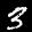

tensor([[ -9.0794,  -8.2172,  -3.3046,   9.0099, -12.2262,  -0.6324,  -6.2912,
          -4.7953,  -1.8685,  -2.9095]], grad_fn=<AddmmBackward0>)
torch.return_types.max(
values=tensor([9.0099], grad_fn=<MaxBackward0>),
indices=tensor([3]))


In [ ]:
from PIL import Image
from torchvision.transforms import transforms
from torch.autograd import Variable

transformer = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
                                  ])

im1 = Image.open("9944.jpg")
newsize = (32, 32)
im1 = im1.resize(newsize)
# Shows the image in image viewer
# im1.show()
rgb_image = np.expand_dims(im1, axis=2)
rgb_image = np.repeat(rgb_image, 3, axis=2)
im1 = Image.fromarray(rgb_image)
im1.show()
image_tensor = transformer(im1)
image_tensor = image_tensor.unsqueeze_(0) #so img is not treated as a batch
input_img = Variable(image_tensor)
output, _ = model(input_img)
print(output)
print(torch.max(output, 1))